In [1]:
%matplotlib inline
import string
from collections import defaultdict
import itertools
import numpy as np
import pandas as pd
from sklearn.cross_validation import cross_val_score
from sklearn import cross_validation

from sklearn.base import TransformerMixin
from sklearn.ensemble import RandomForestClassifier
from sklearn.externals import joblib
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS as stopwords
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC, LinearSVC
# from spacy.en import English
from sklearn.model_selection import StratifiedShuffleSplit
import matplotlib.pyplot as plt

from helper_functions import transform_tweet

/Users/maksym/virtualenvs/machine_learning/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
def prepare_labels():
    emoji = pd.read_csv('emoji.txt', sep="\n", header=None)
    emoji.columns = ["icons"]
    emoji.index += 1
    return emoji

In [3]:
emoji = prepare_labels()
print(emoji.icons.unique())

['heart_eyes' 'yum' 'sob' 'blush' 'weary' 'smirk' 'grin' 'flushed'
 'relaxed' 'wink']


In [4]:
def transform_labels(emoji):
    for i, name in ((0, 'heart_eyes'), (1, 'yum'), (2, 'sob'), (3, 'blush'), (4, 'weary'),
                    (5, 'smirk'), (6, 'grin'), (7, 'flushed'), (8, 'relaxed'), (9, 'wink')):
        emoji['icons'].replace(name, i, inplace=True)
    emoji.reindex()
    return emoji

In [5]:
emoji = transform_labels(emoji)
print(emoji.icons.value_counts())

2    50525
0    39193
4    26855
3    22894
9    18078
1    16790
5    15231
6    15138
8    10472
7    10155
Name: icons, dtype: int64


In [6]:
emoji.values.flatten()

array([0, 1, 2, ..., 9, 2, 5])

In [16]:
def prepare_features():
    tweets = []
    with open('tweets.txt') as f:
        for line in f.readlines():
            tweet = transform_tweet(line)
            tweets.append(tweet)
    return tweets

# def prepare_features():
#     tweets = []
#     with open('tweets.txt') as f:
#         for line in f.readlines():
#             tweets.append(line)
#     return tweets

In [17]:
tweets = prepare_features()
print(tweets[:2])

["vibingoverhoes bet you'll hungry", 'starbucks employee confuses boyfriend saying penis tall']


In [18]:
# Dividing all data for train and test parts
inputs_train, inputs_test, \
expected_output_train, expected_output_test = train_test_split(tweets, emoji.values.flatten())  # matched OK

In [19]:
# Extracting features from text files
from sklearn.feature_extraction.text import CountVectorizer
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(inputs_train)
X_train_counts.shape

(168998, 105092)

In [20]:
# TF-IDF
from sklearn.feature_extraction.text import TfidfTransformer
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
X_train_tfidf.shape

(168998, 105092)

In [21]:
# Machine Learning
# Training Naive Bayes (NB) classifier on training data.
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB().fit(X_train_tfidf, expected_output_train)

In [22]:
# Building a pipeline: We can write less code and do all of the above, by building a pipeline as follows:
# The names ‘vect’ , ‘tfidf’ and ‘clf’ are arbitrary but will be used later.
# We will be using the 'text_clf' going forward.
from sklearn.pipeline import Pipeline

text_clf = Pipeline([('vect', CountVectorizer()), ('tfidf', TfidfTransformer()), ('clf', MultinomialNB())])

text_clf = text_clf.fit(inputs_train, expected_output_train)

In [23]:
# Performance of NB Classifier
import numpy as np
predicted = text_clf.predict(inputs_test)
np.mean(predicted == expected_output_test)

0.44418014307776971

In [24]:
# Training Support Vector Machines - SVM and calculating its performance

from sklearn.linear_model import SGDClassifier
text_clf_svm = Pipeline([('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                         ('clf-svm', SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, n_iter=5, random_state=42))])

text_clf_svm = text_clf_svm.fit(inputs_train, expected_output_train)
predicted_svm = text_clf_svm.predict(inputs_test)
np.mean(predicted_svm == expected_output_test)

/Users/maksym/virtualenvs/machine_learning/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:73: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


0.44760619885324765

In [25]:
# Grid Search
# Here, we are creating a list of parameters for which we would like to do performance tuning. 
# All the parameters name start with the classifier name (remember the arbitrary name we gave). 
# E.g. vect__ngram_range; here we are telling to use unigram and bigrams and choose the one which is optimal.

from sklearn.model_selection import GridSearchCV
parameters = {'vect__ngram_range': [(1, 1), (1, 2)], 'tfidf__use_idf': (True, False), 'clf__alpha': (1e-2, 1e-3)}

In [26]:
# Next, we create an instance of the grid search by passing the classifier, parameters 
# and n_jobs=-1 which tells to use multiple cores from user machine.

gs_clf = GridSearchCV(text_clf, parameters, n_jobs=-1)
gs_clf = gs_clf.fit(inputs_train, expected_output_train)

In [27]:
# To see the best mean score and the params, run the following code

gs_clf.best_score_
gs_clf.best_params_

# Output for above should be: The accuracy has now increased to ~90.6% for the NB classifier (not so naive anymore! 😄)
# and the corresponding parameters are {‘clf__alpha’: 0.01, ‘tfidf__use_idf’: True, ‘vect__ngram_range’: (1, 2)}.

{'clf__alpha': 0.01, 'tfidf__use_idf': False, 'vect__ngram_range': (1, 2)}

In [28]:
# NLTK
# Removing stop words
from sklearn.pipeline import Pipeline
text_clf = Pipeline([('vect', CountVectorizer(stop_words='english')), ('tfidf', TfidfTransformer()), 
                     ('clf', MultinomialNB())])

In [29]:
from nltk.stem.snowball import SnowballStemmer

class StemmedCountVectorizer(CountVectorizer):
    stemmer = SnowballStemmer("english", ignore_stopwords=True)
    
    def build_analyzer(self):
        analyzer = super(StemmedCountVectorizer, self).build_analyzer()
        def func(doc):
            for w in analyzer(doc):
                stemmed = self.stemmer.stem(w)
                yield stemmed

        return func

In [33]:
text_mnb_stemmed = Pipeline([('vect', StemmedCountVectorizer(stop_words='english')), 
                             ('tfidf', TfidfTransformer(use_idf=False)), 
                             ('mnb', MultinomialNB(fit_prior=False, alpha=0.01))])

text_mnb_stemmed = text_mnb_stemmed.fit(inputs_train, expected_output_train)

predicted_mnb_stemmed = text_mnb_stemmed.predict(inputs_test)

np.mean(predicted_mnb_stemmed == expected_output_test)

# now we can save it to a file
joblib.dump(text_mnb_stemmed, 'model.pkl')

print("Accuracy:", accuracy_score(expected_output_test, predicted_mnb_stemmed))

Accuracy: 0.474144817425


In [31]:
for (sample, pred) in zip(inputs_test, predicted_mnb_stemmed):
    print(sample, ">>>>>", pred)

cyrothe y'all really care customers starbucks >>>>> 0
bizziewiiirise " bet can't look smiling look face omg " >>>>> 4
booom strong bet bodell mini wins 3/1 congrats trainer hazel kemp did think … >>>>> 3
fineasskeri mcdonalds gettin nasty >>>>> 2
tell i'm omw beach instead fun say "looking good bet " eiii guys sexual >>>>> 2
simplytheebestt ok bet course >>>>> 3
sabs0ul wants starbucks date >>>>> 6
bet got school tomorrow vallejo don't fuck >>>>> 2
sweet cute bengolis (wait bet) >>>>> 0
neu9l bet cause know sure you're going lose >>>>> 2
beautiful >>>>> 0
y'all bet let nook imma world >>>>> 2
esthermwiza girl yesssss >>>>> 0
i'll bet tomorrow's meeting lot worse yesterday's rnd okeh rnd >>>>> 2
suailysherry bet u did gud 2 congrats ahah 2 nex wik >>>>> 9
missed boxers action afternoon i've got bet >>>>> 5
eggnog chai starbucks season near >>>>> 0
smell fall starbucks flavors air >>>>> 0
patr1ckmccann kebabs kebab house road mcd's &amp; subway lush manchester train home >>>>> 0
pull win

craving mcdonalds >>>>> 4
ohky bet >>>>> 2
vinethropy broke soon heard starbucks >>>>> 6
lunndyy bet kids high school threw muffins lunch thought going happen thank u️ >>>>> 8
oh god >>>>> 2
prettyboyluke bet happened >>>>> 8
cookies subway >>>>> 1
torn taping starbucks >>>>> 2
creativegold lmao love black people like "wtf this" like "damn shit type fire" >>>>> 2
rizzydizzy lanathepisces i'm saying can't mcdonalds >>>>> 2
lunndyy bet kids high school threw muffins lunch thought going happen thank u️ >>>>> 8
omg can't wait >>>>> 0
babyycakkes05 bet thank ️ >>>>> 8
ortizpaola6 aww does somebody need starbucks >>>>> 2
shadysana omgqueen acting bet she's acting able sing >>>>> 0
narcissist wowight bet ️ >>>>> 2
faithjacob yeah bet don't xx >>>>> 9
did hah jk >>>>> 3
youthxcasket bet i'ma day lmao like owner know freaking work schedule bc told >>>>> 2
xingnation promoting exo walmart >>>>> 1
ylexiss bet i'll just >>>>> 0
dealsplus free starbucks life >>>>> 1
got hired walmart &amp; got inte

loriluv11 ladies deserved >>>>> 3
commendationcall winners qcamp altecfambam starbucks tastin' good starbucks… >>>>> 7
actually got discuss personal development plan manager today long overdue i'm happy asm soon baristalife starbucks >>>>> 0
vinethropy broke soon heard starbucks >>>>> 6
dskohicks bet slept good >>>>> 2
finally >>>>> 0
15/100 just can't stop picking cute starbucks cards want >>>>> 2
little things burgerking >>>>> 2
24 ways working coffee shop changes life day starbucks week feel >>>>> 2
traceyeedmonds happy tbt remember s/o 2collegehill's virginiast cast &amp;r collegehillalums luv2ubet's1strealityshow htt… >>>>> 3
yahboycourage wish dominos delivery guy did >>>>> 4
outnumberedfnc love starbucks shareholdersarenotworried >>>>> 0
hakonorr that's great hear mom dad cool they're good how's mommy doing fabulous bet >>>>> 3
blizzylc rihanna got mtv looking like bet right >>>>> 2
brianomarra beladonnaband i'll bet here's pinnacle mountain ark used climb great view pretty >>>>

kind've >>>>> 2
djkhaled bet ain't got sky gonna miss smh able watch tube cos allot shows >>>>> 2
la plz hire starbucks eating soul >>>>> 2
gabbylaesser bet i'm town >>>>> 2
bet you've saw pitbull purse dontbullymybreed happyfriday >>>>> 0
athleticdesires putting starbucks days >>>>> 7
kidsof2018 free $10 starbucks gift card enters >>>>> 0
stackseasonn 10eightten bitch aint hating bet coming >>>>> 2
say "bet" i'm bout real petty >>>>> 2
hxconfidential bet ima slide dms bc im planning trip bihh >>>>> 2
bet got "hey big head" text post lol >>>>> 3
adoringlilo shawnmendes jenerationdiy bet they're secretly dating >>>>> 0
alishamarie nikidemar gabcake thing 2 2 pike place market 2 2 original/first starbucks try 2 earlytheirs line >>>>> 2
bet jack won't congratulate jackmaynard23 >>>>> 9
whatyonameiz want starbucks tacos >>>>> 2
jaypotter23 rhidianr bet sound bar going mental mush >>>>> 5
black woman subway today went tangent black people ignorant >>>>> 2
subway cookies smack >>>>> 1
sofiag

walmart raising wages couldn't happier >>>>> 2
like starbucks cinnabon >>>>> 0
aryandozier life >>>>> 9
ttoodope lilahoodass that's cool bet >>>>> 6
lucykirkh4m just wish mcdonalds did breakfasts day >>>>> 0
berry sangria tea starbucks hellllo >>>>> 0
cobb2000 awww love really he's big boy bet hurt grrrr xxxx >>>>> 2
yolei90 bet yugyeom's stage lit boy sexiest dances + bambam actually knows got7 >>>>> 0
redbonekkay ugly mfs got sexy ass lips bet soft >>>>> 5
mrmcstevie i'll bet >>>>> 0
cbu got starbucks campus >>>>> 2
drizzyxdrea kinglytle24 time thinking need bitch like life bet wouldn't gym putting up… >>>>> 2
feel love target annapolis rude anne arundel county i'm going work fun >>>>> 3
look rappers came atl bet award weekend budget relationships >>>>> 4
sarah wants quit mcdonalds hang >>>>> 2
just met jason kidd starbucks >>>>> 0
iamkarendavila immunity suspects parole convicts lucky men bet bilibid dying testify >>>>> 2
tillerdaily tiller goes subway >>>>> 2
heechiedelahoya that's

i'd like thank starbucks finally serving almond milk >>>>> 0
oh goodness >>>>> 0
casualstaruk bet cummed shortly video stops >>>>> 5
puppuccinohq happy comes starbucks puppies >>>>> 0
michellepmudge mcdonalds >>>>> 2
mcdonalds got bomb ass pancakes >>>>> 4
waynelineker boysif don't remember morninglittle tricktake starbucks >>>>> 9
chicka049 craving starbucks bad cinnamon dolce latte pls banana bread >>>>> 4
subway salad new love >>>>> 0
mommy got starbucks gift card school ️ >>>>> 0
binestom hiddlestonlust don't think bet contemplates lokis behavior >>>>> 9
nikkiskowron god sounds like heaven bet felt unreal >>>>> 2
martafrenkel starbucks ha tuiteado lol >>>>> 6
domtheb0mb hah u wanna bet >>>>> 5
boss just said "okay ladies let's starbucks treat" bless >>>>> 2
away >>>>> 0
bugsmila starbucks playing "all me" i'm trying best god love song >>>>> 2
need feed fabric addiction place near walmart want >>>>> 4
prettydoll w caramel >>>>> 0
it's $80 shipping bet shipping probably push $100 i'd

got starbucks correct order time >>>>> 2
alexandriaprz smh starbucks problem >>>>> 2
mcdonalds ice cream wasn't good night marble slabs it's >>>>> 1
waynelineker boysif don't remember morninglittle tricktake starbucks >>>>> 9
roxydrummond bet raised eyebrows >>>>> 3
i'll game sure got homie ( — bet >>>>> 2
ass weak drayamichele bet pick&amp;choose wanna black >>>>> 2
mcdonalds drive guy just asked flip bottle free fries fucked >>>>> 2
sjvardyy j4depereira ashleighj0shi t4ishh madicaud kayherby teneasaa bet smell like breath >>>>> 0
lizasoberababy bet nyong color ng gown ni liza year's smb >>>>> 6
xashleynicole say feel can't best bet talk that's everybody ️ >>>>> 2
channa release pb members pics u've taken bet it'll oos asap >>>>> 2
agrantofficial craving subway rn bad >>>>> 4
itsfoodporn starbucks >>>>> 1
threw fucking walmart bag birth certificate social security card lot important shit >>>>> 2
immarygracee bet enjoyed shopping bangkok pushawardskathniels >>>>> 0
ambullbronson haha n

shazskye homeless guy just took mcdonalds &amp; walked didn't run guys just walked &amp; started eating >>>>> 2
claretrowell theul nice bet didn't paternoster travel x >>>>> 3
calling police aint causing good >>>>> 2
baeshagates yo best bet fuckin wit catch care >>>>> 2
stephmcmahon tripleh defrancosgym durlancastro brookethomas huge285 wweglamsquad bet 100 squats day wow nice just >>>>> 3
babiebear kwscott29 ntfc yes bet >>>>> 2
starbucks 40oz hydroflask ask nicely >>>>> 3
vibingoverhoes bet you'll hungry >>>>> 0
oh nah fuck nigga >>>>> 2
thevampsjames veggie doubt sammyalbon dominos >>>>> 9
just 30 pc >>>>> 2
excited got starbucks gold card >>>>> 0
buttstrife remember taekook sung 'im love' twice (both v app) bet taehyung listened jungkook pra… >>>>> 5
fact they're putting starbucks campus year >>>>> 2
dominos best pizza crust hands >>>>> 2
moment contemplate waking 9 week old nap dunkindonuts coffee coffeeaddict momlife >>>>> 2
bet you'll sleep memory starts fucking saved >>>>> 2
wa

mijaaaaaaaaa merdeka promo lets 1 baskin robbins 1719 august 2 subway 22 august 3 secret recipe 31 august >>>>> 0
statesnapsog walmart blunt doitforstate statesnaps >>>>> 6
aunt addicted starbucks >>>>> 4
jus mcdonalds >>>>> 4
want starbucks >>>>> 4
lovin' starbucks axis drive >>>>> 0
maal49 ard bet say cdfu >>>>> 2
niggas pullin >>>>> 5
went subway today &amp; lady called beautiful just day >>>>> 2
lunndyy bet kids high school threw muffins lunch thought going happen thank u️ >>>>> 8
lunndyy bet kids high school threw muffins lunch thought going happen thank u️ >>>>> 8
lord kids bet play niece dmaniiiiiiii big >>>>> 2
idol >>>>> 0
dreamchaser257 ashbenzo looks good bet shaymitch love ️ plltvseries >>>>> 5
cheers afternoon cup coffee way hustle dunkindonuts hand workhardplayhard >>>>> 3
need starbucks breakfast >>>>> 4
adethenigerian media isn't going promote movie bet y'all gone theatre august 26th >>>>> 3
just watched 20 min vlog walmart checkout line i'm >>>>> 2
haven't starbucks mo

noriegee pak bet na bet girl mainedcm aldublastcondition >>>>> 0
jdrewswaggie look saw starbucks today >>>>> 0
irfanyaacub subway mcd sr br >>>>> 1
want sheetz late night >>>>> 4
forget extra starbucks fridge >>>>> 2
karlthomas85 woodhousecurtis wow that's reyt bet >>>>> 7
oldscarsmikey bet mean emotional >>>>> 2
afternoons plans hands new cosmopolitan magazine relax starbucks english breakfast tea >>>>> 0
sabs0ul wants starbucks date >>>>> 6
hell naw bet time asked unc ass >>>>> 2
maichardlaspi mainedcm missed walmart aldubdatekay >>>>> 0
grabbed earlier morning >>>>> 2
tiyahshoess right won't >>>>> 2
irfanyaacub subway mcd sr br >>>>> 1
haven't starbucks like 2 weeks >>>>> 2
deaddd >>>>> 2
like subway maybe chinese food >>>>> 2
really craving subway cookies >>>>> 4
got passport ready month subway ️ >>>>> 0
bet jacks thinks i'm good gf saying ditch gym football lads turns just want peace + quiet >>>>> 2
needed 151 bet combo said beat right >>>>> 2
hey dunkindonuts great idea u make ur

guy hella hooked subway lol yassss >>>>> 0
ewericaa "bet" y'all didn't know bradley reason i've happy >>>>> 0
day drive starbucks paid drink >>>>> 2
lmao >>>>> 2
bet happy i'm >>>>> 0
i'd rich didnt spend $50 day starbucks ubers >>>>> 2
maryannjimenez3 kimxifuntasydateinsg 4daystogo bet fave getaways >>>>> 0
jamieball5j starbucks absolutely destroyed blocks hotel courtyardhotels kokomo >>>>> 7
honeyxo bet >>>>> 3
itsfoodporn starbucks >>>>> 1
dunkin starbucks dont care just want coffee iced format caramel (skim milk) large size >>>>> 2
tekaylamarie fairfield needs taco bell starbucks zaxbys chickfila guys wendy's … >>>>> 4
dsteiner247 don't know i'm gonna leave state bet craving worse fml >>>>> 2
words need >>>>> 2
kathipuneras love kath's hairstyles barcelonaaloveuntoldday4 bernardokath >>>>> 0
paulbaja chucknellis tonyromano1000 i'm good gold list absurd "i bet make great wife” sexist stretch >>>>> 9
tifanioliver urge stop starbucks crossfit tough lol >>>>> 4
thatsdm that's female ba

meganlambert can't wait drive bcos means late night drives mcdonalds like 2am >>>>> 1
triggades sho didn't know better >>>>> 5
subway bomb >>>>> 0
whoismeeka know forgot thank anyways fatnose️ >>>>> 3
bet swear >>>>> 2
zachgregory bet love cause >>>>> 2
xdreamspinnerx dxbfan bet they'll try &amp; maroon5 did sugar video da finale >>>>> 2
jlptalk realdonaldtrump kellyannepolls bet tvonetv seanhannity excellent read spot thank speaking truth >>>>> 3
bet depressing wait till june watch oitnb >>>>> 2
vibingoverhoes bet you'll hungry >>>>> 0
mizznewnew21 really mcdonalds wtf lalasizahands89 snapchat (vine lalasizahands89) >>>>> 4
mall starbucks home week thisisweird >>>>> 2
savannasebolt burdenass really smile face bet im gonna spin dem asses run sue weekend >>>>> 2
that's pretty >>>>> 0
chocoloverjen kaillowry bet love jamberry nail wraps here's hubby 2 eldest >>>>> 0
subway smells dead nice morn >>>>> 2
craving starbucks pink drink >>>>> 0
btsjiminph im looking girl sat w/ me&amp; parkjam

gotta fake >>>>> 2
yo nigga treating wrong bet blunt gone make right >>>>> 2
paynepolo hate police let's remove black communities bet mother nature control >>>>> 2
really want dominos today wings pasta >>>>> 4
dear beliebers enjoying swifties doing bet brought justinbieberisoverparty >>>>> 9
bet make atleast loves >>>>> 2
amandahamwells tayloreymard jumping starbucks late night drives ft blasting music bff mom (i love ) ily >>>>> 2
i've 3 >>>>> 2
whoissizzie bet y'all think different women huh nopesame woman lol >>>>> 7
okay that's bet️ drinking early >>>>> 3
lorigreiner yay starbucks finally bantam bagels >>>>> 0
iquotecomedy 10 undercover starbucks drinks need try >>>>> 3
argument mum cause dominos >>>>> 2
really want burgerking just don't feel like going >>>>> 2
time hit dub bet i'll >>>>> 2
cramerskyler bet won't >>>>> 2
barista starbucks thought going school really look young >>>>> 2
subway hit spot >>>>> 1
 >>>>> 0
u r giving bra god ideas >>>>> 2
limmnasty heard blackoutday bet 

bae stops gets starbucks having ask best way start day >>>>> 2
frappuccino starbucks didn't receipt morning >>>>> 2
wanna bet roommate ain't gimme want >>>>> 2
think starbucks sugar >>>>> 4
bet marshall gon try sleep room tonight >>>>> 2
eating southwest salad mcdonalds it's pretty good >>>>> 0
michaelphelps nice meeting u "selenagomez look met subway >>>>> 0
ig i'm going walmart late night snacks >>>>> 2
fuckmytweetraw im bigging yall >>>>> 2
girls eye makeup starbucks >>>>> 0
heading2college free $10 starbucks gift card enters >>>>> 0
want starbucks don't feel like driving wh >>>>> 2
yojynn dyannehae dont lose heart say abt u bet &amp; god; soon b held accountble fr fr oth… >>>>> 2
envyvx yoooo dead b >>>>> 2
college pizza place chinese food place &amp; starbucks steps away >>>>> 2
subway tastes good haven't >>>>> 1
awwwn bet she's cute >>>>> 0
work work work starbucks sm center valenzuela >>>>> 2
heck subway mall doesn't honey oat bread >>>>> 2
walmart stop pickles >>>>> 2
hoping ca

kikemarin arsenal arsenal interested mustafi good opportunity bet signing football https… >>>>> 9
bet let's shopping ️ >>>>> 0
starbucks i've wanted follow ignoring dreams follow >>>>> 2
vibingoverhoes bet you'll hungry >>>>> 0
newdistrict subway >>>>> 0
gotta start em young >>>>> 2
really starbucks >>>>> 4
finally omg >>>>> 0
myabrown423 bet ft lol i'll >>>>> 2
faithfulzoella bet u did great >>>>> 3
means fall moment away ugh summerisending >>>>> 0
man i'm bound bet racky bama beat auburn >>>>> 9
i'm starbucks money >>>>> 2
got protein bet >>>>> 0
iireemy8 bet songbest singer >>>>> 0
texted father pick starbucks 999% sure he'll say didn't text just ignore altogether >>>>> 2
lmfao >>>>> 2
vibingoverhoes bet you'll hungry >>>>> 0
want starbucks >>>>> 4
dominicfrisby bet you'll love bigger cufflink version released huh dom >>>>> 0
bet hey rojamesxix he's turn betfanfront day party fillmore miami >>>>> 0
ay bet ang lock screen >>>>> 0
lady starbucks just said really great smile nice️ >>>>

thevampscon bet you're excited sum 41's new music >>>>> 9
adsm ducesupreme215 ared bet >>>>> 6
selenagomez close 100m followers ig bet reach weekend week >>>>> 2
subway breakfast sheesh >>>>> 4
subway best cookies >>>>> 0
kfc having burger buns left timeyou're having laugh mcdonalds poorservice >>>>> 2
alphamale bae catches cheating try explain "weeell bet ezzznorme" >>>>> 2
itsfoodporn starbucks >>>>> 1
bet ko mgbeach god awful stressful sem >>>>> 2
fuuuuuuuck guys starbucks got damn day problem >>>>> 0
thevampsjames veggie doubt sammyalbon dominos >>>>> 9
starof666 babe gives good head bet cried getting good head >>>>> 2
guwopp lyyrrlyyrr feel lucky ass plus minute shit bet half school don't know is… >>>>> 2
jainkamlesh989 "coincidentally" d pictures represent starbucks listing hkthey aren't american pictures rishibagree >>>>> 2
ah subway steak &amp; cheese sound good right >>>>> 0
subway >>>>> 1
tillerdaily tiller goes subway >>>>> 2
ima let talk want bet touch >>>>> 2
says doesn't 

puppuccinohq happy comes starbucks puppies >>>>> 0
pack oooo starbucks >>>>> 0
bet jams playing videos confessions fave album day lol >>>>> 2
cute firefighter came subway yesterday night rang ask number time >>>>> 0
boblesh i'll bet kaashauer kyle >>>>> 0
elisebrockhurst true ask week bet think it's new best thing >>>>> 2
officialmbmusic bet miss yall >>>>> 2
lmfao jatalie having problems bet james won 1st 2nd afp they'll couple cbs begged bb18 >>>>> 2
xmoneaa that's o gotta starbucks >>>>> 2
happy pill starbucks >>>>> 8
yummy ( subway johor bahru johor) >>>>> 1
aziz a7sek t7b starbucks >>>>> 0
really want starbucks >>>>> 4
da video >>>>> 2
okay cops >>>>> 0
love sangria tea starbucks >>>>> 0
lexiemaee that's bet >>>>> 2
toddufshomber15 right bet dime bg >>>>> 2
love subway wendy's >>>>> 4
marvinashrao wanna bet >>>>> 2
alr bet >>>>> 2
puppuccinohq happy comes starbucks puppies >>>>> 0
gymmike10 ugh bet rescue >>>>> 0
brady thinks ahs leak account real told gullible ass fake n bet wait

bet >>>>> 2
jeongalaxy bet you're cute worries >>>>> 3
phattiecakes need acura know rest ️ >>>>> 2
starbucks sounds bomb rn >>>>> 4
don't starbucks campus >>>>> 4
mcflurry bes >>>>> 0
naw ain't fucking click bitch love bet make hoe bitch >>>>> 2
milkykau play bet you'd loooove >>>>> 2
just got hit old man walmart sendhelp >>>>> 2
coworkers love left starbucks panera gift card desk >>>>> 0
thegod7 bet >>>>> 2
vinethropy broke soon heard starbucks >>>>> 6
bet bundles >>>>> 2
subway met laris >>>>> 0
itsfatimah here's better quality zendaya tom starbucks earlier ️ (credit anthholland) >>>>> 8
doing lol bet >>>>> 2
sweetiebelle329 right starbucks got ran inside said participating store >>>>> 2
tristanspears thought thing she's house htgawm >>>>> 2
he's blends atl look bet tyron love >>>>> 0
got deep fried twinkies walmart >>>>> 4
teamtk u really like starbucks >>>>> 4
banksttu say bet finna petty >>>>> 2
nigga doing classic lip syncing snapchat starbucks >>>>> 2
drink starbucks religiously

man y'all watch >>>>> 2
josiebaik bet good luck >>>>> 3
mercyonjupiter talkin bout pussy ain't tho nigga ain't buy better weave pussy wet >>>>> 2
itsfoodporn starbucks summer drinks >>>>> 0
fazedyn interview walmart today >>>>> 3
bet lit >>>>> 2
gabezilla23 wanna bet >>>>> 2
getinmycarter bet buddy happy ️ >>>>> 3
rgueraa wordnote aww bet️ >>>>> 3
bet y'all didn't know jam tf spanish music >>>>> 2
ain't ask >>>>> 2
bitch should've texted would've brought >>>>> 2
daffodil01chase enjoystaffs bet nice fran >>>>> 9
subway days tasty 6” sub $350 days end y >>>>> 5
bet could've beat laila knee lmao ready >>>>> 2
chanbaekheaven bet baekhyun said "chanyeolah chanyeolah where's seat at" cutesy voice bec look emojis ht… >>>>> 2
need car starbucks run >>>>> 2
i'm watching suicide squad tonight bet it's gonna amazing can't wait >>>>> 0
want starbucks >>>>> 4
feel ashamed coming dd sandwich starbucks hand looking weird stop yall >>>>> 2
zwilson looks like going subway time pick >>>>> 2
hibiscus ber

mcdonalds nasty racist customer 6th avenue racist idiot wants complain fyi 15customers wrong nyc mcdonalds >>>>> 2
lucienparker superduperkyle shouts ight bet >>>>> 3
bet bring >>>>> 2
whoissizzie bet y'all think different women huh nopesame woman lol >>>>> 7
bet 5 niggas smack yal >>>>> 2
statesnapsog walmart blunt doitforstate statesnaps >>>>> 6
subway >>>>> 1
bet bear interview winnerwinnerchickendinner >>>>> 6
theathletesteam putting starbucks days >>>>> 7
littlejesso lol bet >>>>> 2
want subway >>>>> 4
danas4827 dunkindonuts lmao glad make chuckle comedy turn way brighten day >>>>> 3
bgeorgee foreignreligio1 bet jess baby gone come looking like >>>>> 2
lexivibez bet able beat new high score hexavoid >>>>> 0
finding hard bet moved >>>>> 2
francismastromj wait "i bet hes delicious" "i bet hes delicious" >>>>> 0
mindofjjay "u don't wanna attention iight bet gimme money" >>>>> 2
fiftyshadesofax bet kissed night right >>>>> 9
momma surprised tonight nd got mcdonalds >>>>> 0
"the house 

itsfoodporn starbucks >>>>> 1
starbucks class >>>>> 2
soml >>>>> 2
won't starbucks likes gets dutch brosno thanks >>>>> 2
nicki minaj t mobile commercial comes syd says "i bet meek doesn't unlimited data" drakehive >>>>> 4
starbucks cookies n' cream recipe >>>>> 0
juicyyyyfruit bet hope wonderful time >>>>> 2
bet stud fee isn't 125k year >>>>> 2
i'm heaven fact they're waking distance >>>>> 0
morning went dunkindonuts &amp;&amp; asked butterpecan icedcoffee &amp;&amp; said likely discontinued mylifeisover >>>>> 2
cousin bet wear unicorn onesie gym halloween bet >>>>> 2
jenniboooo gotta >>>>> 9
happiest person gave caramel frappe starbucks >>>>> 0
strawberry banana smoothie starbucks >>>>> 1
lunndyy bet kids high school threw muffins lunch thought going happen thank u️ >>>>> 8
mikalawalker drink starbucks needs trytrust >>>>> 0
briizzaaay aint gotta like bet know tho >>>>> 9
isprint817 that's bet i'm >>>>> 3
want subway sandwich toasted ask toast car >>>>> 2
buy leg warmers &amp; hats t

kelleymcnarney takes order starbucks morning final great morning >>>>> 3
noriegee ay bet aldubselflessacts >>>>> 1
gracemcfadden person starbucks bought drink hope person enjoys free drink >>>>> 0
omw starbucks >>>>> 4
queenofpetty wait damn minute walmart got j's >>>>> 7
mancity win champions league bet money winning epl >>>>> 9
bet people defending seen interview >>>>> 2
"i can't believe noah wore leather" morgan "ew bet stunk" >>>>> 4
just know s'mores frap starbucks ️ >>>>> 0
wanna buy dominos >>>>> 4
itsallaboutju kivrasimone def ask kemaria bet agree >>>>> 9
thatdangbee yagurlemzz bet yu wont send location >>>>> 5
mijaaaaaaaaa merdeka promo lets 1 baskin robbins 1719 august 2 subway 22 august 3 secret recipe 31 august >>>>> 0
scoop n lets mcdonalds >>>>> 2
got interview starbucks >>>>> 3
ukafrolista working bet special hair black history month project touch involved >>>>> 3
bytehead brother unemployed doesn't wanna work doesn't wanna eat spinach cabbage eats 4 eggs time >>>>> 4
b

ain't gotta like bet know tho >>>>> 5
sabs0ul wants starbucks date >>>>> 6
puppuccinohq happy comes starbucks puppies >>>>> 0
gassed dominos that's way >>>>> 2
maichardology *cries latin* weren't cam bet kiss underwater kill nao aldubadvocatesoflove https… >>>>> 4
mcdonalds bout >>>>> 2
nebrgenius gives goose bumpstears >>>>> 2
queenofpetty wait damn minute walmart got j's >>>>> 7
bet erk skin lol intimidate >>>>> 2
¡no mamen ¡en subway budapest tienen salsa picante >>>>> 1
deshonnnaaa nigga said" white trash finest" >>>>> 2
don't sell chocolate starbucks damn sure don't >>>>> 2
fkalux realist shit i've come >>>>> 2
today i'm applying jobs aren't walmartbefore going work walmart i'll walk knowing days numbered >>>>> 2
hollywood9276 bet >>>>> 2
went glasgowsubway tonight party glw's tiny subway sooo hilarious >>>>> 2
bhicksfnf lol that's takes man bet luck i'll supporting lol >>>>> 3
bet fake fuck >>>>> 2
vibingoverhoes bet you'll hungry >>>>> 0
armaanmalik22 just listen friends singing

boy subway looked mortified asked lettuce tomatoe sauce sandwich come it's bad >>>>> 2
lyttlekytten bet stars say sav >>>>> 2
imjalen vee4x yes brags abt real bad came starbucks like wht happened gave ass free drink could… >>>>> 2
want subway bad >>>>> 4
ohlifewords wish starbucks mү house >>>>> 0
craving subway's chocolate chip cookies >>>>> 4
funny friend making bet $20 just win game lmao stallions >>>>> 2
problem anytime cutie >>>>> 0
walking walmart saw guy reminded wweaallday21 howyoudoin sawft >>>>> 2
rhyscboyy bet you'd look pretty good >>>>> 5
inezjessel ohh bet >>>>> 9
good ain't subway n >>>>> 2
water gun >>>>> 2
linnyluv starbucks plays lauryn hill >>>>> 2
vibingoverhoes bet you'll hungry >>>>> 0
vinethropy broke soon heard starbucks >>>>> 6
need pumpkin spice latte starbucks >>>>> 0
evanyuson 90's kids rememberthat's right freehold raceway mall prestarbucks >>>>> 7
ima miss twitter bet soon ️️ >>>>> 2
yay babes getting sweet tea mcdonalds i've craving >>>>> 0
sandwich gave 

im tired starbucks better help stay awake >>>>> 2
irfanyaacub subway mcd sr br >>>>> 1
ohnaancy im getting starbucks instead rn >>>>> 2
ohmybeauties josh starbucks blackkingappreciation >>>>> 5
iv bet 8 fixture that's 16 teams 1 goal how's luck >>>>> 2
jhluna53 fucking bet >>>>> 2
totsiepaul bet ko yan can't wait >>>>> 0
bring starbucks work >>>>> 2
scared use subway today >>>>> 2
awww bet called >>>>> 3
samandmarktv bet greggawallace vince vaughan play movie life sam >>>>> 9
looseat bet looked like >>>>> 2
kc2sweet bet pv leave ticket money tho >>>>> 2
kaylajean10 don't single bird bet boots i'm gonna shoot guns texan https… >>>>> 5
teamjalyssa yes boo try tommorow girl text slight tears bet ️ >>>>> 2
efckyle here's lad bet £2000 everton beat sunderland tonight >>>>> 7
ccaasshh u don't like bet ur nigga >>>>> 2
davemoisan heard voice like totally gonna bet great voice >>>>> 2
meghanmarion13 love hearing new stories taylor meeting fans congrats bet tay sweet deserve god bless ️ >>>>> 0

awesome bet topmdw loves >>>>> 3
bethgreasleyx bet dead jealous freebies you've getting thoughxxx >>>>> 2
just like sweet tea >>>>> 0
want starbucks bad >>>>> 4
just applied starbucks >>>>> 2
isn't funny it's hilarious >>>>> 2
dad just took mcdonalds bc knows bad day >>>>> 2
starbucks coming w/so different variety foods pumpkin cheesecake bar sounds amazeballs >>>>> 0
frantically searching starbucks >>>>> 2
tried making pad thai 1st time tagdistrictapp popcorn tagdistrict burgerking… >>>>> 2
jennacagle3 thewalkinprofet shoot bet talk driving 45 minutes just come >>>>> 2
bitingblondie bet she's wifey >>>>> 0
man crush monday type bet treat right >>>>> 2
rainagetro bet q rin c mommy dub aldub1ticket >>>>> 8
dareruin that's awesome real cool guy bet >>>>> 3
onceabc bet >>>>> 2
ohmybeauties josh starbucks blackkingappreciation >>>>> 5
starbucks >>>>> 0
junhyungtv bet hed >>>>> 5
medium rare steak probably bet things tasted >>>>> 0
ofcourse >>>>> 3
sertraline batchmates bet better organizat

subway ihop gus fried chicken >>>>> 2
hjrnabilah guys subway new deals >>>>> 1
bitemyjordans mysiaw32 bet y'all >>>>> 2
haven't gone target >>>>> 2
free $10 starbucks gift card enters >>>>> 0
hyungcity 130) bet yall didnt know jaebum sing good >>>>> 7
puppuccinohq happy comes starbucks puppies >>>>> 0
vibingoverhoes bet you'll hungry >>>>> 0
dobremarcus need starbucks i'm gonna starbucks >>>>> 3
lady starbucks remembers coworker come it's just adorable love >>>>> 0
amazinggvines bet saw like >>>>> 7
what's better going starbucks lunch payed director >>>>> 8
want dominos i'm "diet" >>>>> 4
bet cheesing extra hard >>>>> 2
one's going bring airheads alright bet >>>>> 3
jules1315 bet it's hiding diggerydoo >>>>> 9
mijaaaaaaaaa merdeka promo lets 1 baskin robbins 1719 august 2 subway 22 august 3 secret recipe 31 august >>>>> 0
chiefmulan omg yesssss says "i bet straight a's &amp; shit" lmao >>>>> 2
ohhmyisa girl bet >>>>> 2
free $10 starbucks gift card enters >>>>> 0
sheessooshortt starbuck

starbucks 5 hours >>>>> 2
parker1432 r u kidding names 100x >>>>> 5
flippinginja guys just jared subway guys i'm flippinginja younow >>>>> 0
embogaudo try cold brew starbucks haven't disappointed >>>>> 2
i'm craving chinese food buffalo wild wings wing stop subway whataburgeri need help >>>>> 4
walmart got heat >>>>> 2
want rest subway rn car far sooo close >>>>> 2
couplequotesph starbucks s'mores frappuccino >>>>> 0
mirandyyy she* mom won't bring starbucks >>>>> 2
f0lake drink heavy dairy starbucks drinks events make nervous im lactose intolerant >>>>> 4
trying eat healthy &amp; boss stays bringing starbucks pastries >>>>> 2
starbs you're gonna make broke peppermint mocha psl >>>>> 0
footysupertips ill free fiver bet >>>>> 6
y'all wanna bet ima falling asleep classes week >>>>> 2
xxcarbs edward talaga bet ko season >>>>> 0
ok ordered pizzahut thanks voted️ >>>>> 3
cash4short bet ima definitely speak >>>>> 2
princesspesto0 ugh pls miss dominos can't home need dublin ugh sorry >>>>> 2
b

cjadchallenge adamdewhirst96 captchris93 watch bet adam laughs >>>>> 2
subway >>>>> 1
shut fuck — bet big sis >>>>> 2
akj18 coffee extra creamer bet >>>>> 3
ion use instagram like snapchat watch win bet >>>>> 2
need icecream walmart far away >>>>> 2
thefunnyvine broke soon heard starbucks >>>>> 6
vallyvibes bet able beat new high score tilestop >>>>> 0
bet fbi disappointed nice doj cover time clintoncorruption >>>>> 4
thevampsjames veggie doubt sammyalbon dominos >>>>> 9
bright sun blue skies crème filled maple frosted fave dunkindonuts >>>>> 0
asvpnannie love >>>>> 2
cares studying dice game today hello starbucks >>>>> 0
subway cookies good >>>>> 1
itsfoodporn starbucks >>>>> 1
amandalyn97 niggas shit mans crazy see's doing best bet try plz &amp; thank u >>>>> 2
corleoneig want philly cheese chili cheese fries big mac subway brisk thought gon say some… >>>>> 0
mijaaaaaaaaa merdeka promo lets 1 baskin robbins 1719 august 2 subway 22 august 3 secret recipe 31 august >>>>> 0
bad habit; s

bet feel stupid >>>>> 9
going pennjillette mrteller tonight settle bet debt jamescorden theywontmakeitbacktovegas >>>>> 1
samanthuggg want starbucks >>>>> 2
yourfayvorite uber >>>>> 2
feelings di kit bet tie >>>>> 2
bet i'm going >>>>> 8
starbucks almond milk >>>>> 0
vinethropy broke soon heard starbucks >>>>> 6
starbucks running olympics2016 special i've stayed late week sos teamusa >>>>> 2
abbienichollsx know can't wait uk big fat dominos 10000 pots garlic herb sauce … >>>>> 0
caraagarrigann mcdonalds >>>>> 2
don't like bet know >>>>> 2
bet lads got p's girls d's resultsday >>>>> 3
mreneafrisby starbucks tried ordering yesterday &amp; don't fall hotchilemocha fave fall drink >>>>> 0
topicforeva want mcdonalds >>>>> 4
andymac bet goal wasn't discussed preseason >>>>> 3
umj102490 roger leo bumalik dolceamoresabwatan >>>>> 0
want starbucks >>>>> 4
imarijacole bet did great >>>>> 3
swing sets just kids lately don't bet kid jump >>>>> 2
totally just remembered dad bought subway left >>>>>

matthewdcfc dorselator know i've seen bet chose fulham >>>>> 0
arlenexo omg iknow bet >>>>> 2
got free starbucks drink >>>>> 0
mrmime tipton teamblue mysticrules hahaha son mr mime bet didn't expect… >>>>> 9
layallauren i'm excited fall holidays boots &amp; jackets rainy days starbucks red cups >>>>> 0
starbucks today >>>>> 0
teylashaye did tupac exist 50 cent hell meek movie >>>>> 2
thefunnyvine broke soon heard starbucks >>>>> 6
madiischultz i'm craving starbucks >>>>> 4
free $10 starbucks gift card enters >>>>> 0
border patrols nice ass booties bet ass gonna staring we're waiting border >>>>> 3
makaylaaa want starbucks >>>>> 0
soon cazzara >>>>> 6
mredtrain carmine bet that's taken care cleaning a1 delta team >>>>> 6
tritter429 starbucks target >>>>> 4
lizanianz tataklizquen da serena explained don simon fm confrontation bet xander agnes ft jay pusha… >>>>> 2
wanna bet careful >>>>> 0
beechloren02 bet geo sneaking pictures >>>>> 2
starbucks >>>>> 0
banksttu say bet finna petty >>>>>

know it's going good day barista starbucks tells look beautiful mademyday >>>>> 2
dead presidents bet >>>>> 2
pizzahut ayy pizza hut follow ill good time catch drift >>>>> 3
garrettcoates &amp; katielane26 wishes come true thanks starbucks >>>>> 2
ok bet >>>>> 3
callumcafc99 bet you're crapping mate >>>>> 9
sometimeswhenimalonei eat munchkins dunkindonuts >>>>> 1
sometimessav i'd home bc bet make sex w best >>>>> 2
oh i've missed starbucks … >>>>> 2
really hate greensboro like erica bet ask >>>>> 2
way real wtf expect mcdonalds >>>>> 2
nikkidohertyy1 walmart work moving grand opening can't >>>>> 2
fucking shit >>>>> 2
skynews bet doesn't wear trousers garylineker pants week >>>>> 9
howiecarrshow sharethis oh boy bet that's water bottle >>>>> 2
dawnchats freebies4mom oreo walmart people eat eyes let customers help walmartvoteoreo >>>>> 0
thought starbucks free bc cute just free starbucks working brick house 24/7 shirt >>>>> 2
finished chapters algebra mood skrg movie makan makan starbuc

alysiahunter that's dad williams oral maxillofacial 5th new walmart he's super good >>>>> 0
kaaayyg subway * >>>>> 2
irfanyaacub subway mcd sr br >>>>> 1
time starbucks coffee jitters >>>>> 2
uenvydae ain't gotta like bet know doe >>>>> 5
said needs starbucks emoji >>>>> 2
jejakatopman met starbucks damn fine >>>>> 0
woah just got recognized starbucks >>>>> 7
thefatinbella resist sedap sangatttt foodporn mcdonalds food foodie foodgasm icecream… >>>>> 0
maggiebaugh samhunt yeah bet >>>>> 9
best friend hits city island got grub iight bet ended >>>>> 2
come mcdonalds >>>>> 0
norbertdog oh goodness that's quite nice bet slept you're mom bed iknowyourtype imamaltesemom >>>>> 2
got best season college hill bet demand >>>>> 4
really want hot coffee starbucks >>>>> 4
thereallmaree treat treat bet they'll learn lesson >>>>> 5
vickijee bet sedate civil >>>>> 5
man drive line mcdonalds deadass just gave woman blender >>>>> 2
alicesmithy fairness bet u️ >>>>> 3
kcbxox bet come homecoming >>>>> 3
t

subway lunch >>>>> 8
yooblock jeongyeon momo's bed quite small persons bet complain >>>>> 5
imrioliza namiss ka ni water hahaito ung bet kong smile mothank u khapon i'm supporting matter ️ https/… >>>>> 8
stank >>>>> 2
kvyuyu i'm heading starbucks lunch >>>>> 8
starbucks morning finish homework great >>>>> 3
vibingoverhoes bet you'll hungry >>>>> 0
simplysaun0043 bet >>>>> 9
juditamondryk phenomenari jtmarshyy bet £20 don't >>>>> 2
getting starbucks babe saltedcaramelchocolate >>>>> 0
bet >>>>> 2
girl damn baby wouldn't worry bout thang — bet >>>>> 2
ciara absolutely stunning bet video >>>>> 0
crying >>>>> 2
40hypnotiq lizquenpexersny || newyorkloveslizquen bet you're lizquen heaven can't wait vids pics push… >>>>> 0
twoamtina mcdonalds glad did loveeeee fries >>>>> 0
“sassydiva909 bet >>>>> 2
hqboangers lizquentatakstarmagic bet quen took pic pushawardslizquens >>>>> 0
lunndyy bet kids high school threw muffins lunch thought going happen thank u️ >>>>> 8
dejajharne | video explicit be

thefunnyvine broke soon heard starbucks >>>>> 6
sillyslater bet wouldint swap mummies x >>>>> 9
sulewskisarah mood starbucks >>>>> 0
planetjedward omggg morning bet it's just awesome songs sooooooo excited >>>>> 0
thefunnyvine broke soon heard starbucks >>>>> 6
armaanmalik22 just listen friends singing to"bol na zara" love betjust listen ×28 >>>>> 3
don't sleep walmart deli $398 >>>>> 4
jesus christ $109k month child support kids payless shoes walmart clothes bihh fighting >>>>> 2
subway ou kfc — subway >>>>> 4
sadly coming realisation 'one off' mcdonalds' make hell difference bikini >>>>> 2
reklawanoira bet darrianarnold ya >>>>> 9
randomvines bet saw like >>>>> 7
callmemaicaa bet bet come house nomo (without knowing) >>>>> 2
trainer shopping tomorrow bet won't like >>>>> 2
millie99xoxo haven't like 4 starbucks sweden need town i'll try time >>>>> 2
perks working starbucks >>>>> 0
bet ft bitch answer >>>>> 2
hawaii mcdonalds sells cinnamelts >>>>> 2
mijaaaaaaaaa merdeka promo lets 1 b

kristenakellya going walmart time need really hate going >>>>> 2
i'm getting subway later i'm happy >>>>> 0
lunndyy bet kids high school threw muffins lunch thought going happen thank u️ >>>>> 8
stephygrainger f0dffb919787403 terrier4life borobaldy86 yeah bet >>>>> 9
tikisoka rains orrow bet lot brave just aldublpultimatebattle >>>>> 5
6 years ago today bet ass probably happiest person watching hannah montana school >>>>> 2
starbucks runs work know orders starbucks workers best friends >>>>> 2
hahaha dumb twit blaming ear piece learned boss bet nevertrump imwithher >>>>> 2
i'm willing bet money atlanta elementary school teacher white woman hotep coons "white girls " >>>>> 2
starbucks >>>>> 0
tragesseraustin god things starbucks officially started mourning ripstarbucks >>>>> 2
smilebeth1994 breathtakingly beautiful just walking subway can't breathe >>>>> 0
god bet shoot nigga today chrisbrown nigga better shot today >>>>> 2
lindasuhler it's telling isn't hillary's mental happy place lis

lisanicolemusic pr 604now thx writing great article amarmirch bet you'll learn new ht… >>>>> 3
rufushound i'll bet £10 noneu gb signs ttip >>>>> 2
puppuccinohq happy comes starbucks puppies >>>>> 0
conzycronzy retweet luke lawless wrecks head don't know it's safe bet just retweet >>>>> 2
brandon ass night dead ass sleep woke getting cursed >>>>> 2
just caved got starbucks ice coffee damn alarm goes >>>>> 2
makes happier starbucks >>>>> 0
snehajo know best season pumpkin spice latte email starbucks >>>>> 0
muzzymuzzles bet don't cover college >>>>> 9
booooooooooooooooom winnerrrrrrrrrrrrrrrrrr >>>>> 6
quincy hey big head >>>>> 0
life advice eat subway cookie cold better warm >>>>> 4
hottathanwasabi starbucks whip cream nother level >>>>> 0
starbucks didn't strawberry açai heartbroken >>>>> 4
"you ain't gettin ya food tho" >>>>> 2
bsallack can't wait >>>>> 7
chelsyerenetaaa don't really drink starbucks >>>>> 4
subway sounds delicious right >>>>> 1
starbucks >>>>> 0
want starbucks >>>>> 4

gucci mane house arrest bet need freekodak freebobbyshmurda >>>>> 4
subway surfer et bientot mario inshaallah >>>>> 6
lunndyy bet kids high school threw muffins lunch thought going happen thank u️ >>>>> 8
37 getting subway sf like >>>>> 9
nana owes dubb cause lost bet ion know knew gonna lose >>>>> 2
imradiorahem facts >>>>> 2
akshaykumar thank ashvini >>>>> 3
lmao fr >>>>> 2
man got starbucks morning >>>>> 2
queenofpetty wait damn minute walmart got j's >>>>> 7
mom getting subway >>>>> 2
i'm cracking >>>>> 2
moonlightbabe ur cutest >>>>> 2
kalyndabaddest bro pizza hut &amp; dominos that's shit >>>>> 2
melindahoward4 oh bet >>>>> 3
knowing dexter bet killed >>>>> 2
happens order ice black tea lemonade starbucks oppositeday starbucks >>>>> 2
new starbucks smores frappuccinos look amazing >>>>> 0
imactuallywes can't good looked weekend bet looked better person >>>>> 0
mcdonalds breakfast lunch today don't feel guilty self ordering menus just fun use >>>>> 2
monster7abby said isu starbuck

mijaaaaaaaaa merdeka promo lets 1 baskin robbins 1719 august 2 subway 22 august 3 secret recipe 31 august >>>>> 0
themadisongrace awesome where's drink starbucks looks good btw >>>>> 0
raspberry cheesecake cookies subway kierra >>>>> 1
got mom starbucks >>>>> 2
you'll blessing like baby bet >>>>> 0
emelielb libbytanner ewam78 hsl772 wentworthrehab bet >>>>> 3
bet lucky asf >>>>> 2
early appointment tomorrow love starbucks i'm just saying maraisepicgmailcom >>>>> 2
trey songz >>>>> 2
dunkindonuts finally joined ddperks >>>>> 0
spent £12 starbucks n costa today look like i'm starving till pay day x >>>>> 2
trillhailey sammee girland bet u gonna slayy >>>>> 3
arreionnufsaid ohh delish af bet >>>>> 1
evansngori bae reaction tryna explain bet money meant food arsenal spoilt >>>>> 2
itsfoodporn starbucks >>>>> 1
bet new bridget jones movie cheer watching sully love bridget jones big grandma panties lol >>>>> 6
ohemmeg easiest poll participated hate mcdonalds >>>>> 4
starbucks 4 weeks straigh

green tea starbucks good >>>>> 0
sabs0ul wants starbucks date >>>>> 6
brought starbucks >>>>> 0
avminvh bet u wish >>>>> 5
subway sounds soooo flame rn >>>>> 2
kimjonesxx dominos larveeeeely >>>>> 4
ilustdahvie iepicooki3 botdfmusic bet beautiful fucking sight >>>>> 0
cooper got starbucks yesterday texas state university >>>>> 2
bet happy birthday augustalsina >>>>> 0
bet ima wait till realize shit >>>>> 2
leqendarystar want big breakfast hot cakes mcdonalds breakfast >>>>> 4
stancollymore bet you're thousands lfc fans say virtually week "he's good enough" >>>>> 9
guess requirements beyoncé promote tour commercial deal bet >>>>> 2
johnnyrockhill judycockerton roderobijn jbix909 glafiz ozoneparkpatti wraithsword dunkindonuts fruit &amp; veggies healthier >>>>> 3
oh fuck man >>>>> 2
caught guard >>>>> 7
bet today turned including bama covering >>>>> 9
got orientation tomorrow walmart blessed >>>>> 2
"it starbucks" >>>>> 0
jewelehlerss starbucks doing right bc started selling pumpkin spic

subway pizza >>>>> 1
micaylac7 really wanna drive petro rn psl starbucks >>>>> 2
thequeencee bet wish >>>>> 4
ishinebest bet won't happen >>>>> 8
libby6001 shaunacook amyahiax joshanderson1 chloebechares01 bet he's sat thinking "fuck again" >>>>> 2
banksttu say bet finna petty >>>>> 2
mcdonalds replies indirects >>>>> 2
httpisaac cutie just stopped walmart said supporting 2 years soooo cute adorbs >>>>> 2
shy sheetz >>>>> 0
puppuccinohq happy comes starbucks puppies >>>>> 0
damn knew walmart cute ass employee >>>>> 2
ronibrooke1 def hop u know meanhomeboy fine rhony >>>>> 4
people walmart kept looking hives making ugly faces >>>>> 4
misjorgiepoer bet beautiful 5am >>>>> 0
kelloggsus rainy sun risen day post olympicgames excitedly waiting paralympics begin teamusa >>>>> 3
somebody bring sweet tea mcdonalds >>>>> 4
ngchelseafc fa bet diego costa receive 10 match >>>>> 0
colleenb123 miss sooooo >>>>> 2
esaindigena *try's laugh * nahhh bet they're good soo way it's good >>>>> 2
love starbu

carolynmarie6 girl know look bomb af bet ass >>>>> 2
vibingoverhoes bet you'll hungry >>>>> 0
reunited bestie london arianad niece starbucks smilesandchinos >>>>> 0
bet learn >>>>> 5
khollllt0n bet u >>>>> 2
heidycortesss perfect weather hot starbucks warm cookies blankets &amp; netflix >>>>> 0
free large fries hot fudge sundae bessssst loyal customer >>>>> 0
andrsnh ah ha bet they'll superb entering gbbotwitterbakealong kuskus1 &amp; robcallen >>>>> 0
ewinbieberr dominos having special buy pizza free >>>>> 0
mistystonexxx chanellxxox i'm public strong erection bet y'all taste heavenly >>>>> 0
lunndyy bet kids high school threw muffins lunch thought going happen thank u️ >>>>> 8
damndessa you're person order pumpkin spice latte starbucks >>>>> 0
starbucks lady spelt "shannel" wtf >>>>> 2
females don't liking explanation ask female don't like &amp; bet says ' just don't ' >>>>> 2
meghanwmccarthy m meghan america mcdonalds alldaybreakfast add snapchat mwmm i'm http… >>>>> 6
centexmatt sw

boomerbanks bet it's w damn good party >>>>> 1
haydenantonelli dunkindonuts addiction real >>>>> 0
johan3sixteen provided best meal bias tells mcdonalds demolished pack nuggets dinner >>>>> 2
dirickvangiel bet you're making hungry great day >>>>> 0
erinwilliams09 bet i'm gonna look >>>>> 3
muniirr wear suit it's supposed come confidence power sabalifashion best bet >>>>> 9
cerysfruin bet did >>>>> 4
kayela saw leaving shirt room invitation wash &amp; wear bet >>>>> 2
glad just bet $100 5 blow break really really bad >>>>> 2
alicegarcia928 awww ka abang2 itheey s ksgrabe excited aldub59thweeksary >>>>> 3
starbucks mi hermano >>>>> 0
yippe >>>>> 0
latimes latimesopinion bet audience lent bible he's probably held hands >>>>> 5
evanyuson 90's kids rememberthat's right freehold raceway mall prestarbucks >>>>> 7
mrchristianwebb bet you're chuffed ️ >>>>> 3
"nigga fuck uh thousand it" >>>>> 2
funnyvideogame dude mcdonalds playing pc >>>>> 2
subway maccies kfc space 4 hours need stop day thing

bcimhann lol bet i'm coming let petty >>>>> 2
mijaaaaaaaaa merdeka promo lets 1 baskin robbins 1719 august 2 subway 22 august 3 secret recipe 31 august >>>>> 0
prickett70 bet >>>>> 2
mama steady talking laylay tutu kain &amp; cody party bet >>>>> 2
vibingoverhoes bet you'll hungry >>>>> 0
awkcliffordd you're starbucks >>>>> 0
rglolz bet >>>>> 2
theydreadjojo fooling walmart malosoarroagant runningmanchallenge >>>>> 2
fav >>>>> 0
thefunnyvine broke soon heard starbucks >>>>> 6
omg bet di >>>>> 0
went starbucks instead chilli mochayummy time lisa x bosslady >>>>> 0
lunndyy bet kids high school threw muffins lunch thought going happen thank u️ >>>>> 8
yahboycourage wish dominos delivery guy did >>>>> 4
amandaaa31 want starbucks >>>>> 2
lunndyy bet kids high school threw muffins lunch thought going happen thank u️ >>>>> 8
thatdangbee yagurlemzz bet yu wont send location >>>>> 5
bet gonna dream tonyt >>>>> 2
just sat thought money spend month starbucks cus day >>>>> 2
mikaarianna bet nomina

think son catchin cold goin walmart soon medicine >>>>> 2
juiceg0dd bet ima ou say joke don't mad >>>>> 2
yummy chilimocha starbucks >>>>> 1
cwlovemusic ah gotcha fun bet u better internet huh >>>>> 9
i'm officially coffee snob i'm basically holding nose drink starbucks >>>>> 2
bet night life chancetherapper >>>>> 4
i'm excited yeri's teaser waaah bet she'll beautifuln >>>>> 0
shomaristone sinow umichfootball bet sparty hating getting new motivation >>>>> 0
 >>>>> 0
subway days tasty 6” sub $350 days end y >>>>> 5
sangria berry herbal tea starbucks >>>>> 0
came starbucks sad bc forgot wallet remembered starbucks app >>>>> 2
6godessa bet smell good >>>>> 0
schofe awww lovely bet proud dad >>>>> 3
bae tweets >>>>> 2
cakeclips bet delicious >>>>> 1
need starbucks closer house >>>>> 4
bet catch u slippin runnin yo mouf cuz make time seee u >>>>> 2
drypenis iseekicks23 bet amors >>>>> 0
maliaquarles bet y'all seen comin >>>>> 9
bet wholesale good quantity order a… >>>>> 3
subway isn't going

dxddym mother talking nails long fathers getting called bet nails long >>>>> 2
chick fil &amp; starbucks wake >>>>> 2
sabs0ul wants starbucks date >>>>> 6
does family 16 kids &amp; counting afford school shoes bet clarks love i've got 2 &amp; kerching £70 later >>>>> 2
fuck girls bet wondering >>>>> 2
tell texas people mess clicc youtube link bio real music coming soon >>>>> 2
kill dominos pizza right sadly i'm broke that's option >>>>> 4
bizziewiiirise " bet can't look smiling look face omg " >>>>> 4
lmao you're lemme you're rider >>>>> 2
alpalcrystalgal bet energy place >>>>> 2
ayshardzn just realised there's ebi burger like japan omg ordering mcdonalds >>>>> 2
guccitierrezzz bet lmao >>>>> 2
 >>>>> 0
neekcholas bet didn't know share birthdays >>>>> 9
want subway >>>>> 4
bet babe sleeping rn >>>>> 2
i'll bet taste like water >>>>> 0
eirenarch stranger danger bet android smh >>>>> 2
baetard bet freckles remain >>>>> 2
kiaraanjane bet dollar >>>>> 3
meeting potential client week starbu

xalexapacheco bet don't aps yelling 2 seconds late >>>>> 2
superrsydd "um wanted service people starbucks dream" liike >>>>> 2
adamharmon91 skyfootball arsed bet naisy gonna score don't start chiming just cos it's 10 >>>>> 2
oh look 10th kiddo ️ >>>>> 0
want starbucks >>>>> 4
want pancakes mcdonalds >>>>> 4
ngl bet you've forgotten facts danisnotonfire >>>>> 2
rosariumbill alternate reality bet >>>>> 2
bet sweet ass >>>>> 2
en subway >>>>> 0
miss debbie man door starbucks cup 10am >>>>> 2
kayjacurry want subway >>>>> 4
bet perfect10 hayday >>>>> 2
bammm2x jstkaylaaa thanks bae &amp; u bet i'll later ️ love ya >>>>> 0
lovely brief encounter dear old friend nantes (brought starbucks ) so… >>>>> 3
itsfoodporn starbucks >>>>> 1
joining snap today bet st8farmjake proud >>>>> 3
fidi burgerking playing drake giving 15% orders letting extra sauce chicken friesgoodjobbk >>>>> 2
salted caramel frappucino starbucks sounds good right >>>>> 0
wendyr38224819 jamieeast bet like work better too; stir 

taylortwellman let's make legal tax >>>>> 7
bet sucks rn ️ >>>>> 4
coolkiddoamm wow bet felt dumb end >>>>> 2
starbucks il pay >>>>> 4
stated applying jobs yesterday bc really don't want work starbucks anymore just got forever 21 >>>>> 2
want starbucks >>>>> 4
bet drop gym location >>>>> 2
chrissyeliz oh boy bet noticed >>>>> 2
just need walmart >>>>> 2
want subway >>>>> 4
xoisaabel bet moms happy asf bc we're going school >>>>> 2
hope bet doesn't play brotherly love death >>>>> 2
theathletesteam putting starbucks days >>>>> 7
cornforthderek bet didn't listen you're growing grass visit cheese fruitcake long overdue reckon >>>>> 3
man looked mcchicken trend thinking mcdonalds new deal hate twitter >>>>> 2
need starbucks rn >>>>> 4
kinda know feeling >>>>> 2
miahippie movie bet makes paranoid asf >>>>> 2
bet new era redhair shank yonkou >>>>> 4
"taylor blonde hair blue starbucks let buy coffee time" >>>>> 0
kaylaahenderson funnyvines lol starbucks uggs amhs u aint change >>>>> 2
kind >>>

bae tells "stfu" bet >>>>> 2
footballtipsnl screen bet want big balls professional oh wait bankrupt scam liar >>>>> 9
got dollar meal walmart thank u >>>>> 3
brianaspiffy bih movie watching bet >>>>> 2
thefunnyvine broke soon heard starbucks >>>>> 6
victorkilgen mallorybodin bet know >>>>> 5
guyonthetwits fall starbucks coffee >>>>> 0
jacksqueen1828 bet blames thinks he's burden ppls sched did good he's angel ht… >>>>> 4
update ariekkae bringing subway >>>>> 0
mstreetbakery gorgeous keepsake bet absolutely loved beautiful cake xxx >>>>> 0
gave mc cause ain't griddle >>>>> 2
justinsklaus lady starbucks just gave free >>>>> 0
puppuccinohq happy comes starbucks puppies >>>>> 0
thevampsjames veggie doubt sammyalbon dominos >>>>> 9
theathletesteam putting starbucks days >>>>> 7
bet teacher bumping abn way school morning rain >>>>> 2
rebelrebel36 bet magnificent >>>>> 6
bet saw sooner &gt; >>>>> 7
couplequotesph starbucks s'mores frappuccino >>>>> 0
jennyxhemaj order mcdonalds >>>>> 2
collee

eggsootic favorite drink starbucks >>>>> 0
lunndyy bet kids high school threw muffins lunch thought going happen thank u️ >>>>> 8
i'm really craving subway >>>>> 4
man bet aggravate tee >>>>> 2
itsfoodporn starbucks >>>>> 1
lunndyy bet kids high school threw muffins lunch thought going happen thank u️ >>>>> 8
ohwowsimpao69 trucked shit outta >>>>> 2
i'm learning chicago bet beat paytonstolp trivia >>>>> 9
naciakelly time stop starbucks sangria tea >>>>> 0
liaoxanne think it's safe bet >>>>> 9
heart eyes boy bet doesn't notice >>>>> 2
available locations >>>>> 5
lunndyy bet kids high school threw muffins lunch thought going happen thank u️ >>>>> 8
bet jalena laughing bad ic >>>>> 2
vibingoverhoes bet you'll hungry >>>>> 0
starbucks deliver chai tea latte >>>>> 4
dominos got deal >>>>> 1
haydenhunt15 mclovin1111 coltonhooten19 i'm cali idaho bet ass come ol jake >>>>> 2
dick pussy bet feel toes >>>>> 5
carrieelee10 stephhalex wait i'm getting starbucks >>>>> 0
lol bet laga lein aap win >

totallyrachel moment free birthday drink starbucks restocked s'mores frappuccino https… >>>>> 0
theydreadjojo fooling walmart malosoarroagant runningmanchallenge >>>>> 2
just want starbucks >>>>> 4
excited starbucks >>>>> 0
i'm starving just want mcdonalds >>>>> 4
graacielag craving pink drink starbucks >>>>> 0
c2wtweets joego101 expression looks like lost bet got bike >>>>> 2
leezasm i'm willing bet aldubsilanabaay >>>>> 0
shawnmworid shawn boston spotted starbucks wondering >>>>> 3
waitin dining room table bet shit wrong time >>>>> 2
tillerdaily tiller goes subway >>>>> 2
charliejones aw that's sweet bet proud erhello >>>>> 3
chanielford26 ceeep7 jannacarla mas bet ko bg song help gusto ko ulit manood barcelonaaloveuntoldday9 >>>>> 2
beat bunch niggas dominos turn paying today's car wash wax jaz appreciates y'all ️ >>>>> 2
witchywoo40 bet u guys lovely walks ideal world mum live st boxer owners ️ >>>>> 0
bet >>>>> 2
irfanyaacub subway mcd sr br >>>>> 1
jordainwebb notvsco bet >>>>> 2

thetidedrew yasssss new music just need guysss bet it's awesome >>>>> 0
somebody tell doors just opened subway going ttchelps anxiety >>>>> 4
jessierosaless shit bet >>>>> 5
free $10 starbucks gift card enters >>>>> 0
xavien praying mantis leaving mcdonalds tell it's good luck mcdonaldsi $5 >>>>> 4
sauvidotcom svnnmnr starbucks coffee liquor store caramel flavor it's like synthetic cocaine >>>>> 2
bruh fuck herelmao bet shows crib throws events *relocate >>>>> 2
i've fallen love acoustic version ciara bet >>>>> 0
s/o boss mcdonalds >>>>> 0
albyselkie aliljaded4u2 it's okay safe space it's guns bet comes shock candacetx antifox… >>>>> 5
dropped starbucks morning >>>>> 2
hqboangers lizquentatakstarmagic bet quen took pic pushawardslizquens >>>>> 0
julialug14 little starbucks action >>>>> 8
jamieball5j starbucks absolutely destroyed blocks hotel courtyardhotels kokomo >>>>> 7
damn man bet ol red dog rip carmichael sure >>>>> 2
ian worried bout lil burnt crisp >>>>> 2
kingkiraaaa subway so

really want mcdonalds >>>>> 4
btsjiminph im looking girl sat w/ me&amp; parkjammin95 starbucks yesterday aftr concert u forgot ur wallet pls https… >>>>> 2
migueeell bet soul smells like weed >>>>> 2
lilmissreddog bet can't wait just finished worked i'm countdown >>>>> 3
mrskpop1 bet 1 million dollars yongguk watched v app smile face >>>>> 3
really wanting starbucks right >>>>> 4
lunndyy bet kids high school threw muffins lunch thought going happen thank u️ >>>>> 8
victoriaasotelo mcdonalds fucks stomach >>>>> 4
pettykrueger making starbucks run gotta work hour wbu >>>>> 2
it's good day starbucks instead having psychology >>>>> 2
ricky don't starbucks comes ima upset girl️ >>>>> 2
bet barry doesn't say damn thing >>>>> 2
jackieortega97 y'all tmobile free chicken sandwich subway >>>>> 1
theeloho tweet blew time bet god's working favor >>>>> 2
starbucks make oreo drink >>>>> 0
lesleyashworth great day modafashion nec birmingham choosing gorgeous shoes lexus >>>>> 0
hair cute did today to

seandante vibing yawa iammayorkun watch dope tune ft skillojacson bet beats yawa https… >>>>> 9
worst diet weekend 3 maccies dominos chinese >>>>> 4
liked dunkin starbucks jump free coffee thing >>>>> 2
marquisebatey went subway thinkin gettin free sub fuckin pay >>>>> 2
joshuareidhead bet amazing feeling little boy's day >>>>> 0
gypsysxvl mannnnnn atm's walmart said people change cards >>>>> 2
"streamlife don't play" omg just faint right guys just dropped freshest bet time like dang ihipsterlee >>>>> 2
nirah oh okay lol need big walmart >>>>> 2
loyaltysamust somebody bring caramel macchiato starbucks >>>>> 4
enics bet you'd bitter i'm going bestival manchester derby >>>>> 2
need boba starbucks >>>>> 2
yay starbucks ️ >>>>> 0
2 whoppers cheese 2 fries 2 drinks burgerking doin' right >>>>> 0
noticed today mta riders actually defer older people kids subway >>>>> 7
okay bet >>>>> 3
starbucks disappointed iced coffee basically iced water worst $3 spent >>>>> 2
edemreigns man united spoil u

beating everybody >>>>> 2
statesnapsog walmart blunt doitforstate statesnaps >>>>> 6
marimotax33 damm shawty bet hang night lmao >>>>> 2
new study place >>>>> 0
can't wait subway >>>>> 0
fighternthekid double domwildthing witness ultimate bet >>>>> 7
khadiunique starbucks campus >>>>> 0
veronicaapplee really want starbucks rn >>>>> 4
mcdonalds fries yesterday self control broke million pieces >>>>> 2
sjm1878 bet alcohol weighs fruit >>>>> 7
wikileaks genius trump tax returns bet u can't >>>>> 9
remynochaser youngforevea bet bet i'll seeing tm babay >>>>> 0
milothedachsund fanx matey it's like looking mirror bet ️ >>>>> 2
hannah woke mcdonalds >>>>> 2
lunndyy bet kids high school threw muffins lunch thought going happen thank u️ >>>>> 8
yo rs >>>>> 2
heyvioletfam just huge menu mcdonalds im happy >>>>> 0
lilkekev happy it's fall favorite drink starbucks >>>>> 0
mom got starbucks asked >>>>> 2
akshaykumar thank ashvini >>>>> 3
weekend >>>>> 2
anissalavigne ramibrownboy amazing buys starb

mimzz year starbucks gets rid carmel flan latte panerabread gets rid sierra turkey >>>>> 4
itsfoodporn starbucks >>>>> 1
lucyboxer93 bet able beat new high score slip away >>>>> 0
want subway rn >>>>> 4
mia got fat eating subway wow just got smoothie wow tho >>>>> 0
girl subway aggressively going seat saw suitcase don't let tell nyers jerks >>>>> 2
trillroach bitch im clean bet checked cleaner win &amp; yall polluting earth thats l >>>>> 2
maybe times wondering bet mainedcm doesn't single bit di ba beh aldublessonsoflove >>>>> 0
bout died threw bun >>>>> 2
mikalawalker drink starbucks needs trytrust >>>>> 0
bet real nigga look eyes >>>>> 2
starbucks gift card >>>>> 0
woke wanting subway >>>>> 4
cakeclips bet delicious >>>>> 1
i've wanted cool high schoolers got starbucks late start mom won't >>>>> 2
anit way >>>>> 4
bitxh wanna war wit bet ain't gettin sleep >>>>> 2
shelbymae120 good person paying people starbucks ️ >>>>> 2
mzkayel ken ken si quen ang wheel lizken way pushawardslizquen

sabs0ul wants starbucks date >>>>> 6
really venti berry sangria starbucks >>>>> 0
kenyaaaa lol bet️ tho >>>>> 2
theylovearii sister got recognized mcdonalds drive ommgggakaoocfolfb >>>>> 2
arianamcgeary34 dalilalatorre bet watch thing >>>>> 2
dad's volkswagen mokka streetpass slot racer probably driving soon nintendo nintendodirect 3ds gaming volkswagen >>>>> 0
better ready hearts wonwoo tho handsome >>>>> 0
lindasuhler it's telling isn't hillary's mental happy place list bet she's happy place https… >>>>> 5
vibingoverhoes bet you'll hungry >>>>> 0
d1cats bollocks bet you're no5 aren't stay rounds it's >>>>> 4
going starbucks band sub didn't >>>>> 2
wait mcdonalds >>>>> 0
meganporters bet osu wishes uninvested private prisons asked >>>>> 3
craving starbucks pulak dah >>>>> 2
did walmart schedule today day day >>>>> 2
kind morning wish cos bet we're 989% snoozealarmismorningbae >>>>> 2
imfpn bet >>>>> 2
lauren just went mcdonalds 3 windows drove second foodobviously lauren driving ️ >>>

ikonintl [info] bi won subway ads hongdae displayed october fanmade ️ >>>>> 8
christhegoatt want bald head girl >>>>> 0
bet >>>>> 2
theregodimples bet taste good af >>>>> 1
karaelizabeth3 juliastaub ben owes 2 trips starbucks steelers winning >>>>> 3
starbucks card giving life manila collecting socute jeepney… >>>>> 0
tiadeshay k michelle nut ye plays smart sake entertainment bet need she's cap >>>>> 2
itsfoodporn starbucks >>>>> 1
lmfaoooo >>>>> 2
jtizzle206 haha bet link 6 lemme >>>>> 9
went payless wishing von's cost u wishing costco heading kmart wishing walmart/target ih8gu >>>>> 2
bet can't guess movie dante 50 dates created monster >>>>> 2
rupikaverma starbucks >>>>> 1
miss emmajd mcdonalds >>>>> 2
starbucks post doesn't psl >>>>> 2
want subway >>>>> 4
"&amp; bet say won't " >>>>> 2
id best progress report a1 attendance >>>>> 2
mariabby21 starbucks today ️ >>>>> 0
subway cookies >>>>> 1
suppose nigga >>>>> 2
evanyuson 90's kids rememberthat's right freehold raceway mall prestarb

bethcrissmcfly jamesbourne amercia bet loads cool pokémon x >>>>> 3
lady starbucks handed coffee like "omg love freckles" ️ >>>>> 2
tenaceousb1u bet 3 >>>>> 2
vibingoverhoes bet you'll hungry >>>>> 0
starbucks barista super nice complimented tattoos dumb ones memorized order >>>>> 2
he's libra >>>>> 3
thank dunkindonuts creating 200 point free beverage coupon brings great joy >>>>> 0
sunneesummer danilordbraga bet >>>>> 2
contacts supposed today bet waiting til monday >>>>> 2
dominos nooo i'm trying order just want dominoes money wanna free dominoes coz i'm loyal customer >>>>> 2
brotherly love rey come bet know it's rey weak >>>>> 2
want starbucks >>>>> 4
graysondolan saying suck singing &amp; think you're lyin bet good voicedolantwinsnewvideo >>>>> 2
starbucks barista flirts you're mom think you've got boldman feelingprettygood >>>>> 2
avminvh bet u wish >>>>> 5
valeriaaaaa13 "i got book favorite starbucks drink turn page 323 it's favorite" >>>>> 0
immarygracee bet enjoyed shopping b

akshaykumar thank ashvini >>>>> 3
taniababyx wait til mcdonalds mcgriddles day maaaaaaan ️ >>>>> 4
evangelicx sister just want bet day birthday️ >>>>> 0
starbucks school >>>>> 8
10feetmikeg micheleeee bet idk right >>>>> 4
got dominos there's food house got free garlic breadmeant >>>>> 0
really need pink drink starbucks >>>>> 4
kookieangeluk bet you've driven today we're looking change soon trying talk oh golf >>>>> 3
milliebushell omg know know day finally arrivedbet won't able stop napping >>>>> 2
guy subway gave 10% cause said i'm regular >>>>> 2
frap season starbucks frap frappuccino potd latergram ottcity foodporn cottoncandy 2016 >>>>> 0
laurenkataya61 bet does speak care mom >>>>> 2
starbucks chantelfuss hey look it's nicaragua miss >>>>> 0
subway heard ask "get 9/11" dontbedumb >>>>> 6
kaylaraereid i'll bet looking good >>>>> 0
ebnlufcx oh god bet can't wait thing induction week took 5 days >>>>> 2
alanaboyles dunkindonuts yesssssss summer fulfilled >>>>> 0
bet can't afford bey

starbucks raspberry ice tea >>>>> 0
thereallmaree treat treat bet they'll learn lesson >>>>> 5
migraine (at dunkindonuts smithtown ny) >>>>> 2
waynelineker boysif don't remember morninglittle tricktake starbucks >>>>> 9
irfanyaacub subway mcd sr br >>>>> 1
itsfoodporn starbucks >>>>> 1
thereallilkayla right >>>>> 2
thatssoharsh psa starbucks bakery items $1 today >>>>> 0
theydreadjojo fooling walmart malosoarroagant runningmanchallenge >>>>> 2
lunndyy bet kids high school threw muffins lunch thought going happen thank u️ >>>>> 8
day leave bet memories follow >>>>> 2
gorgeouslust oh god i'm screaming >>>>> 2
bugsmila starbucks playing "all me" i'm trying best god love song >>>>> 2
itsfoodporn starbucks >>>>> 1
natedaafrican walmart ain't playing >>>>> 2
thanks jay starbucks >>>>> 2
that's bet >>>>> 2
happy birthday rushammermma flowy soni bet nobody's tweeted >>>>> 6
wtvrkatelyn he'll let buy meal won't let pic tragic >>>>> 4
yeahh should've gone mcdonalds >>>>> 3
imjustjocelyn everytim

bugsmila starbucks playing "all me" i'm trying best god love song >>>>> 2
cs0mers316 "everyday" "you music me" "bet it" said >>>>> 2
craving starbucks >>>>> 4
jongasm help think mcdonalds yeri >>>>> 4
want iced caramel mocha mcdonalds >>>>> 0
clyde616 bet pic close hand >>>>> 2
grindb4shine god >>>>> 2
drinking soda cause starbucks isn't open relapsed >>>>> 2
got drink free today best customer service starbucks >>>>> 0
illegal people post snapchat stories dominos night mun >>>>> 2
tillerdaily tiller goes subway >>>>> 2
scared subway >>>>> 2
told starbucks barista nice eyes gave drink free >>>>> 0
trying pumpkin spice frapp &amp; it's delicious starbucks >>>>> 0
lexmasterflex adgshaunnn lol bet coming cute >>>>> 0
thefunnyvine broke soon heard starbucks >>>>> 6
hellcatjesi ummmm called love handles missy bet girls hatin hahaha >>>>> 9
just want pizza grilled cheese mcdonalds bacon cheeseburger >>>>> 4
know girl starbucks paid coffee gave free iced macchiato >>>>> 0
accepting application

bet >>>>> 2
it's baaaack >>>>> 7
bugsmila bet camila crying backstage hearing sounds beautiful >>>>> 2
im hired mcdonalds >>>>> 2
simoonehh hope bet focus characters who's favorite far (erik course) >>>>> 3
spencermusic1 girls new try starbucks >>>>> 0
leeparkjeen starbucks partttyyyy >>>>> 0
xoxomckays know starbucks fav comes pumpkin >>>>> 0
chick fil express starbucks looks like itll ready ️️️ uapb uapb20 >>>>> 8
mcdonalds better fries better >>>>> 0
eilidhblair rlly dominos chinese >>>>> 2
bet phone died >>>>> 2
anybody trynna bring mcdonalds >>>>> 2
percxcet mcdonalds employees attitude >>>>> 2
like subway good workout >>>>> 2
arinaeunie skipped work bet she's happy kid >>>>> 3
want subway >>>>> 4
mallowandmarsh special mallowmondays celebrate starbucksuk launch win £20 starbucks &amp; mallows >>>>> 0
missing nose ring minute need walmart asap >>>>> 2
mijaaaaaaaaa merdeka promo lets 1 baskin robbins 1719 august 2 subway 22 august 3 secret recipe 31 august >>>>> 0
hausoffirat gaga 

kiss thighs &amp; eat pause minute let bet >>>>> 2
ewals64 expressen pictures brilliant bet gig high >>>>> 0
derby conceding minute lose bet >>>>> 2
aldubnations lola's playlist ultimate battle na happy watching sino bet nyo aldublpultimatebattle >>>>> 3
happy birthday birthday twin >>>>> 0
banksttu say bet finna petty >>>>> 2
say hello new safeway starbucks barista job 2 >>>>> 0
koreaboo happy birthday subway signs cute here's fans nayeon's birthday seen happynayeonda… >>>>> 0
poorjim6060 bet entrants pros related judges >>>>> 6
just thinking makes >>>>> 2
brother got job starbucks better hook >>>>> 2
met sweetest guy starbucks today >>>>> 0
kyliahhhhhhhhh powerhouse lineup lil corny bet >>>>> 2
bet can't like >>>>> 2
burgerking stop puppers got cheeseburgers sissy got chicken sammich whopper didn't make bag hazardofroadtripwithpups hangry >>>>> 4
cakeclips bet delicious >>>>> 1
mcdonalds makes mcgriddles day >>>>> 2
yesterday funniest day walmart >>>>> 2
nope got subway ️ >>>>> 2
hey

wait movie (at starbucks coffee epicentrum walk) [pic] — >>>>> 0
aabele starbucks smoothie >>>>> 1
school ima babies burger king stephanie fat ass just want subway real real bad >>>>> 2
listening random people starbucks speak french >>>>> 2
starbucks guy remembers >>>>> 2
starbucks covers drinks wait long &gt;&gt; >>>>> 0
work busy manager gives $50 lets leave early starbucks >>>>> 2
starting work starbucks friday's means free drinks >>>>> 0
starbucksru thank hearts starlivibaristas rutgers starbucks rutgersdining rustartruck >>>>> 0
cameron just bought starbucks >>>>> 0
boy smell like mcdonalds >>>>> 0
just saw 6'10" guy iga i'll bet doesn't need help reaching shelf >>>>> 2
starbucks >>>>> 0
bet yall won't sell yall $5 juicewars ticket >>>>> 2
tattsgreat kc66keith marksfc50 valkeep bet he's asleep lol sorry >>>>> 2
sabs0ul wants starbucks date >>>>> 6
damndessa you're person order pumpkin spice latte starbucks >>>>> 0
juliemartinezz starbucks hires cuties like >>>>> 0
bet class quiet 

sandykaybaru glad picked alextheir connection electric startespecially chocolate bathtub datei bet money… >>>>> 3
itsfoodporn starbucks summer drinks >>>>> 0
theydreadjojo fooling walmart malosoarroagant runningmanchallenge >>>>> 2
think burgerking gave food poison >>>>> 2
inesslesliee pumpkin spice sauce >>>>> 0
sad subway house isn't 24 hrs anymore >>>>> 4
brothatsekane finna skee dick bitch i'm knowing ok bet >>>>> 2
want subway&gt; >>>>> 0
bet def drop cash live >>>>> 2
kylaaolani hell yeah bet discounts niceeeee wish work that's easy slay >>>>> 2
thank god starbucks >>>>> 2
chasebraelonii subway pizzas >>>>> 1
time starbucks new people work &amp; mess drink >>>>> 2
maseratichoppas nah everytime c u post automatically like "ima yall niggas im nun 2 played with" >>>>> 2
ran kitten mom mcdonalds parking lot immediately drove >>>>> 2
redspoder eagalway dominos >>>>> 4
theathletesteam putting starbucks days >>>>> 7
awaiting 'free' £10 bet 888sport >>>>> 0
mijaaaaaaaaa merdeka promo let

hukateandwillie happy worldlionday bet guess favorite lions >>>>> 9
tobethebt ahhhh snoozies bet right ear twitching listening dad >>>>> 6
igococo dominos cokeesports pringles 7up slush puppy fruit juice just ice water >>>>> 0
worse conceding 93rd minute goal fucks bet >>>>> 2
bet good time >>>>> 2
kylieyapkaini let reach target term exam >>>>> 2
person heard c bomb advert pizzahut theladbiblegrp whoops pizzahut ladbible >>>>> 6
jhadabae bet man >>>>> 2
stopping starbucks right penn medicine good idea doctors leaving lunch >>>>> 2
"bet" doe >>>>> 5
blaming jun minghao attending fanmeet manila god sake bet it's fault >>>>> 2
richthugger wendys nuggets better mcdonalds location wanna physical debate >>>>> 2
daihuntr legend edition gold* bet >>>>> 0
keyarasimone idk acted different i'm gone bet miss >>>>> 2
aww lady starbucks called pretty >>>>> 0
there's old man woman holding hands walmart goals >>>>> 2
pro tip best way destroy blackberry use little ball eating mcdonalds french fries fri

powerfulpetyr sansaofnorth || mmm adventures lord chaos fun bet >>>>> 9
fintga omg wanna meet bet vixen >>>>> 2
redbonekkay ugly mfs got sexy ass lips bet soft >>>>> 5
craving subway bad >>>>> 4
dakidm0 "med school" toothe game >>>>> 2
free $10 starbucks gift card enters >>>>> 0
chick johnny rockets told taking mcdonalds casinos biggest fast food chain world >>>>> 2
literally saw playing inna car >>>>> 2
subway hit spot >>>>> 1
ordered 2 joey specials dominos patrick happy boy >>>>> 0
heathhussar video's shoutout new tfil video lost bet >>>>> 4
sounds good rn pineapple mushrooms olives chicken banana peppers jalapeños added >>>>> 1
hoes bet fuck juvie >>>>> 5
garethshanks did bet north end we're decent shout >>>>> 2
tatabaldeo bet na bet sir roxy ️ pushawardskathniels >>>>> 8
belfasthour stop working home/ starbucks you're better >>>>> 2
backupmindyobiz love carmel brûlée latte starbucks winter >>>>> 0
bought fresh batch fries mcdonalds way home work got home tripped porch steps &amp; 

fuck bitches acting shady ask nigga bet drove crazyyyyy >>>>> 2
paytonjo &amp; peytonreese21 bet &amp; ima win >>>>> 3
leslierubio5 want starbucks >>>>> 4
boyy im kist know seeing &amp; yous mf lie bet going frfr finna pop playing >>>>> 2
ninagutierrez4 looks way vanessa looks subway sandwich >>>>> 4
sukkbiggdikk g0dsentme4u just wanna dig tiggerreddxxx just like bet ass universe >>>>> 0
smart >>>>> 2
bet slim u dont walk away dont bluff >>>>> 2
tmobile coming subway >>>>> 1
met savings target quarter year >>>>> 2
question buying 60 pods coffee amazon $50; think twice walk starbucks 2 cups sugary drinks $20 >>>>> 2
like miss >>>>> 2
starbucks >>>>> 0
mickeyfs fans fickle bet wouldn't boo unfurling flag >>>>> 3
pointlessblog hpplayldn incredibly jealous bet bloody amazing️ >>>>> 0
got subway cookies >>>>> 1
harold's good hood u bet eat >>>>> 2
koreaboo happy birthday subway signs cute here's fans nayeon's birthday seen happynayeonda… >>>>> 0
patiently waiting line subway girl paid order

want starbucks real bad just don't feel like driving >>>>> 2
facts >>>>> 2
mavkg ah nice bet amazing did whilst ) thankyou >>>>> 0
kekepalmer love guys >>>>> 0
dunkin donuts coffee &gt;&gt;&gt;&gt; starbucks coffee >>>>> 0
dobremarcus need starbucks i'm gonna starbucks >>>>> 3
andrearoze1 bet >>>>> 2
really want starbucks >>>>> 4
bet snake bigger >>>>> 2
bet thought wings interested jam rags didn't >>>>> 2
bet >>>>> 2
dyosaabbyabello craving starbucks >>>>> 4
want subway soooo bad >>>>> 4
tylerrjoseph dare u drop selfie use emoji bet ur chicken >>>>> 2
richcrewpinkyy bet y'all bars >>>>> 3
game bet season i'm gonna bet $50 it's saints50 >>>>> 2
celinegranda salmonwonder awh️ thanks friendship bet ko yung thicker love thank surprise ps… >>>>> 0
home tv bet i'm watching >>>>> 2
subway know throw shit >>>>> 2
daniellealexisb vidasocali bet fa um tho crip >>>>> 2
hwallop bet you'll going >>>>> 0
jonadelosreyess problem bet daiso gonna sell >>>>> 2
starbucks saving lives rn >>>>> 2
don't kn

beautifuibloom beautifuibloom just confirm venue outside starbucks moa arena 5pm ty >>>>> 3
firearmswmp wmawp bet happy add nomination peep delegation >>>>> 3
hannahmedlam14 bet >>>>> 2
pub grandparents used starbucks >>>>> 2
large gins bet >>>>> 0
fams came surprise mcdonalds meal >>>>> 2
sportstipsterus dusted inside 2 periods thats 4 winners 5 bets world cup fantastic betting high quality… >>>>> 3
starbucks >>>>> 0
moment just added $10 starbucks hour it's gone starbucksaddict >>>>> 2
theregodimples bet taste good af >>>>> 1
free $10 starbucks gift card enters >>>>> 0
starbucks iced white chocolate mocha heart >>>>> 0
really want starbucks bring >>>>> 4
briannaakersxo pasttt mf tense hoe bet ate pussy right kissed yo ass >>>>> 2
mcdonalds app gone fat af >>>>> 2
bugsmila starbucks playing "all me" i'm trying best god love song >>>>> 2
totaltippinguk ppl havent placed bet guess play safe just 05 goals instead >>>>> 2
iphone 7 plus bet big iphone 6 plus >>>>> 9
damn >>>>> 7
super late

thefunnyvine broke soon heard starbucks >>>>> 6
kelsifrigo bet u wish u didn't play >>>>> 9
waynelineker boysif don't remember morninglittle tricktake starbucks >>>>> 9
bizziewiiirise " bet can't look smiling look face omg " >>>>> 4
javajava say i'm going eat betterbut end craving mcdonalds middle night >>>>> 2
smoiow bet nervous moment waiting handsome face telly >>>>> 0
josikatee lady infront mcdonalds just paid food alanistupper >>>>> 2
ohlifewords wish starbucks mү house >>>>> 0
cocainemontana bet don't forget ain't gone hold just >>>>> 2
theydreadjojo fooling walmart malosoarroagant runningmanchallenge >>>>> 2
iquotecomedy 10 undercover starbucks drinks need try >>>>> 3
kinyree aww bet it's >>>>> 6
cute starbucks dates best️ >>>>> 0
movie bet got weak >>>>> 2
jejuanw bet >>>>> 2
dominos pizza forever deliver >>>>> 4
head dartfordtoll bet traffic insane dartfordcrossing >>>>> 5
bet spencer bought toby's house caleb prettylittleliars pll >>>>> 4
ultimateulric thought i'd try bet won

awww gotta pay accept payment starbucks coffee >>>>> 3
sincerebella new bet bby you'll love >>>>> 0
thebronzeone bet patron make feel nice comfortable >>>>> 5
dying subway >>>>> 2
today sooooo good >>>>> 2
lunndyy bet kids high school threw muffins lunch thought going happen thank u️ >>>>> 8
bet live stream bomb af can't watch >>>>> 4
omgggg wish jordan >>>>> 2
olivia's 2nd time hitting said "i bet wont" just stood >>>>> 2
kyripdepz footyaccums bro team hard moms time bet won like 70 >>>>> 2
paigeegilbert bet >>>>> 2
bizziewiiirise " bet can't look smiling look face omg " >>>>> 4
desperate need starbucks coffee bottle >>>>> 2
awkward conversation subway man uno say just goes wrong 'you staying going out' 'yeah' >>>>> 2
diondmwaldner bet rock hipster look >>>>> 9
punderwoman bet wears gloves aswell >>>>> 9
emilyg823 tomorrow >>>>> 2
bring >>>>> 4
wonderfulvk tae sooo turned bet he's just containing feels &amp; glancing bf sneakily taek… >>>>> 0
having pizza dominos tonight can't wait >>

rxchelallen ffsveronica starbucks >>>>> 0
morning errands starbucks &amp; im naked couch happy friday fridayfun >>>>> 2
mannys buying mcdonalds >>>>> 4
that's big bet >>>>> 2
day felt like bad bet movie >>>>> 2
dlashaeee bet bet play emotions >>>>> 2
saw post look myselfwhen tf did walma sta selling j's fam letmefindout >>>>> 2
remember mcdonalds cups use design >>>>> 2
lucyboxer93 bet able beat new high score slip away >>>>> 0
gotta bet luckiest having lol >>>>> 2
footysupertips challenge bet 2 wins posting bet 3 w/ 150+ likes late join sign bet365 &amp; play ▶ ht… >>>>> 2
wishing starbucks near job >>>>> 4
won bet >>>>> 2
sydwayout bet didn't >>>>> 2
super bet ang caption asapagostothemax iamandalioloisa >>>>> 0
got head shot hit target twice good weekend ️ >>>>> 2
btsjiminph im looking girl sat w/ me&amp; parkjammin95 starbucks yesterday aftr concert u forgot ur wallet pls https… >>>>> 2
javachip >>>>> 0
sweatin itsbae >>>>> 2
kidboltt flaw… bet can’t >>>>> 5
avocadglow starbucks wr

binkbackwood xxbreeeee lmaooo bet ima talkin stress free >>>>> 2
storeyally bet >>>>> 2
dad like "why tell threw away walmart clothes" cause did lmfaooooo don't fuck ️ >>>>> 2
craving starbucks >>>>> 4
thecheerbook free $10 starbucks gift card enters >>>>> 0
aw you're cute ilysm >>>>> 0
know coffee natural laxative does shit morning starbucks just pee >>>>> 4
vibingoverhoes bet you'll hungry >>>>> 0
rebebasurto berry refresher >>>>> 1
thing college that's making excited dominos delivers cheesy bread >>>>> 4
iisuperwomanii know >>>>> 2
staytrillhill ight bet >>>>> 3
omg guys really want starbucks right >>>>> 4
urbandoll got chile mocha starbucks >>>>> 0
milkshaykee think leaving bet won't >>>>> 5
really nice cake place buhaira right starbucks called roche nice fine came cake >>>>> 0
kimflem80587330 cbearfalpal janetplank awlasky aww that's sweet bet he's thinking right >>>>> 6
iisuperwomanii know >>>>> 2
youenvyrika bet just holla ️ >>>>> 5
iamkingashlee 18 23 bet she's mature female >>

best friend got fight didn't respond shows house starbucks says' "hi bestfriend" >>>>> 2
randomvines bet saw like >>>>> 7
redbonekkay ugly mfs got sexy ass lips bet soft >>>>> 5
llysllys bet >>>>> 2
thefunnyvine broke soon heard starbucks >>>>> 6
mcdonalds sweet sour sauce >>>>> 4
claire takes starbucks >>>>> 4
unholyperrie tortas uhm subway super easy make delicious >>>>> 4
tillerdaily tiller goes subway >>>>> 2
bet nachos shit >>>>> 2
simonbell3 bet she's great diver >>>>> 3
thefunnyvine broke soon heard starbucks >>>>> 6
gurnie starbucks makes day️ >>>>> 2
love good days got free starbucks drinks reason did good eval work blessup >>>>> 0
laylacorchado bet feel dumb asf >>>>> 2
time starbucks swear puts better mood >>>>> 2
trichbaseball15 dominos real mvp >>>>> 0
bjw2 woowwww aight bet >>>>> 3
fyooe5 cumrolad st pirans bet >>>>> 3
thefunnyvine broke soon heard starbucks >>>>> 6
say im craving icecream hourwhos gonna bring mcdonalds send text 'your icecream come now' >>>>> 2
lunndyy b

want starbucks bad >>>>> 4
tell niggas tried talk ran subway helllobarbie slimnassty >>>>> 2
trying cut starbucks life going hard >>>>> 2
obsessed starbucks cups mugs >>>>> 0
got starbucks happygirl >>>>> 6
waynelineker boysif don't remember morninglittle tricktake starbucks >>>>> 9
got sparkly sticker cold brew reason dunkindonuts just employee going extra mile >>>>> 2
really wanted m&amp;m mcflurry mcdonalds ice cream machine stay broken >>>>> 2
hope u didn't bet usc >>>>> 2
theathletesteam putting starbucks days >>>>> 7
im just asking tyrone questions questions bet annoyed wishmewell >>>>> 2
omgggggg want bad >>>>> 2
fucktyler notice bet frank ocean >>>>> 4
bet wont ok tho️ >>>>> 5
subway days tasty 6” sub $350 days end y >>>>> 5
ohmybeauties josh starbucks blackkingappreciation >>>>> 5
don't matter it's monday tuesday wednesday bet crush >>>>> 3
vijimusings nehajoshi02 guptamohona nataliesamson1 yeah spark bet swara &amp; sanskar >>>>> 8
ohh ok ️ thanks subway >>>>> 3
rashford just

In [23]:
print("Confusion: ", confusion_matrix(expected_output_test, predicted_mnb_stemmed))

Confusion:  [[6391  232 2209  273  517   52   47   41   32  146]
 [ 817 1637  991  118  491   45   18    4   38   72]
 [ 965   98 9395  317 1231  111   49   51   52  243]
 [ 857   79 2244 1890  255   81   55   32   45  224]
 [ 660   88 3075  140 2494   32   39   35   22  110]
 [ 404   38 1447  205  195 1229   37   17   17  265]
 [ 515   31 1212  271  190   56 1224   14   24  181]
 [ 149   13  900   63  144   31   13 1165   13   72]
 [ 453   30  951  210  101   39   25    9  713   76]
 [ 571   46 1508  402  207  148   67   32   24 1446]]


Confusion matrix, without normalization
[[6391  232 2209  273  517   52   47   41   32  146]
 [ 817 1637  991  118  491   45   18    4   38   72]
 [ 965   98 9395  317 1231  111   49   51   52  243]
 [ 857   79 2244 1890  255   81   55   32   45  224]
 [ 660   88 3075  140 2494   32   39   35   22  110]
 [ 404   38 1447  205  195 1229   37   17   17  265]
 [ 515   31 1212  271  190   56 1224   14   24  181]
 [ 149   13  900   63  144   31   13 1165   13   72]
 [ 453   30  951  210  101   39   25    9  713   76]
 [ 571   46 1508  402  207  148   67   32   24 1446]]


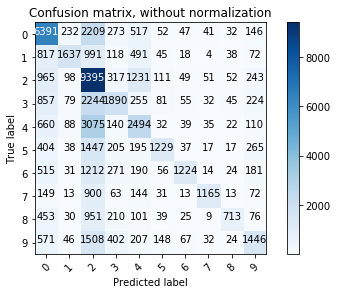

In [24]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
cnf_matrix = confusion_matrix(expected_output_test, predicted_mnb_stemmed)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes = emoji.icons.unique(),
                      title='Confusion matrix, without normalization')